# Pre-Processing and Training Data Development: CBARQ Survey

### Problem: Does dog breed affect behavioral traits, specifically chasing (or herding)?

The purpose of this project is to assess how dog breeds affect behavioral traits, with the focus narrowed to chasing (see previous EDA step of this project for explanation why). Therefore, here I will create dummy variables for the breeds and conduct a train/test split. I will not need to use a scaler, as all of my independent variables will be dummy values (binary 0s and 1s).

In [4]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split

In [5]:
# Evaluate dataset created during EDA to double-check for missing values and datatypes.

df = pd.read_csv('C:/Users/Guest1/Desktop/Uni/Springboard/Puppers/Data/cbarq_eda.csv')

# print(df.isnull().sum())

# print(df.describe())

# print(df.head())

# print(df.columns)

# print(df.dtypes)

# Remove extra columns
# df = df[['BreedID', 'chasing']]

In [6]:
# Creating dummy/indicator variables for the categorical data, BreedID (10 values)

dummies = pd.get_dummies(df['BreedID']).astype('int')

# Create a dataframe with the dummy variables, excluding the original column

df_final = pd.concat([df, dummies], axis = 1).drop('BreedID', axis = 1)
df_final.head()

,Unnamed: 0,trainability,chasing,excitability,attachatten,energy,Australian Shepherd,Border Collie,Doberman Pinscher,German Shepherd,Golden Retriever,Labrador Retriever,Mixed Breed/Unknown,Poodle (Standard),Rottweiler,Soft Coated Wheaten Terrier
0,0,4.125000,3.25,1.666667,1.666667,3.0,0,0,0,0,0,0,1,0,0,0
1,1,3.750000,3.00,2.833333,3.000000,2.0,0,0,0,0,0,0,1,0,0,0
2,2,4.285714,4.25,3.833333,3.666667,3.0,0,0,0,0,0,1,0,0,0,0
3,3,3.250000,2.75,3.333333,2.833333,2.5,0,0,0,0,0,0,1,0,0,0
4,4,4.500000,2.75,3.000000,2.166667,2.5,0,1,0,0,0,0,0,0,0,0


In [53]:
# Separate X and y dataframes

X = df_final[['Australian Shepherd', 'Border Collie', 'Doberman Pinscher',
              'German Shepherd', 'Golden Retriever', 'Labrador Retriever','Mixed Breed/Unknown', 
              'Poodle (Standard)', 'Rottweiler','Soft Coated Wheaten Terrier']]

y = df_final[['chasing', 'trainability', 'excitability', 'attachatten', 'energy']]

(5629, 5)

In [8]:
# Split data into training and test sets. (70/30 or 80/20)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 55)

In [9]:
# Since all of my X values are binary 0/1 dummy variables for breeds, I don't need to use a scaler.

Narrowing this dataset to just 'chasing' and breeds makes it far simpler and eliminates a lot of the noise generated by some other traits which didn't show very clear relationships. The reasoning for this limitation is in the EDA portion of this project.

The data has been separated into training and test sets, as well as X and y variables (with chasing being the y, dependent variable, and the breeds being the X, independent variables). All X values are 0 or 1, and y values ranging from 1-5 (as they were acquired through a survey which used those numbers for rating). 

# Modeling

The main function of this model will be to see if it can give a rough value, from 1-5, predicting a dog's herding behavior from its breed. X values are breed dummy columns, y values are 'chasing' values ranging from 1-5, with 5 being the highest herding tendencies and 1 being none at all.

Since we are predicting a continuous numerical value, we will be using regression models. To get a good variety and assess what works best, we will try Linear, Logistic, Ridge, and Lasso models, and we will be altering hyperparameters of those which seem most promising.

In [15]:
# Set up our imports

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold

In [16]:
# Let's start with a Linear Regression model.

lin = LinearRegression()

lin_params = {'fit_intercept' : [True, False], 
             'copy_X' : [True, False],
             'positive' : [False, True]}

lin_search = GridSearchCV(lin, lin_params, scoring = 'neg_mean_squared_error')

lin_search.fit(Xtrain, ytrain)

print("The best negative MSE score for a Linear Regression model is " + str(lin_search.best_score_) 
      + '\nThe best parameters are ' + str(lin_search.best_params_))

The best negative MSE score for a Linear Regression model is -0.7485746361602028
The best parameters are {'copy_X': True, 'fit_intercept': True, 'positive': True}


In [17]:
# Lasso regression model

lasso = Lasso()

lasso_params = {'alpha':[0.01, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1], 
             'max_iter':[800, 900, 1000, 1250, 1500, 2000, 2500]}

lasso_search = GridSearchCV(lasso, lasso_params, scoring = 'neg_mean_squared_error')

lasso_search.fit(Xtrain, ytrain)

print("The best negative MSE score for a Lasso Regression model is " + 
      str(lasso_search.best_score_) + '\nThe best parameters are ' + str(lasso_search.best_params_))

The best negative MSE score for a Lasso Regression model is -0.7536399105522057
The best parameters are {'alpha': 0.01, 'max_iter': 800}


In [18]:
# XGBoost model

boost = xgb.XGBRegressor()

boost_params = {'n_estimators':np.arange(80, 120, 10), 
             'max_depth':np.arange(1, 16, 2),
             'eta':[0.4, 0.3, 0.2, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01]}

boost_search = RandomizedSearchCV(boost, boost_params, n_iter = 50, random_state = 52, 
                                scoring = 'neg_mean_squared_error', return_train_score = True)

boost_search.fit(Xtrain, ytrain)

print("The best negative MSE score for an XGBoost model is " + 
      str(boost_search.best_score_) + '\nThe best parameters are ' + str(boost_search.best_params_))

The best negative MSE score for an XGBoost model is -0.7483085775567475
The best parameters are {'n_estimators': 80, 'max_depth': 3, 'eta': 0.04}


In [19]:
# Random forest regressor

rfr = RandomForestRegressor()

rfr_params = {'n_estimators':np.arange(80, 120, 10), 
             'criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
             'max_depth':np.arange(1, 10),
             'min_samples_split':np.arange(2, 15)}

rfr_search = RandomizedSearchCV(rfr, rfr_params, n_iter = 30, random_state = 52, 
                            scoring = 'neg_mean_squared_error', error_score = 'raise')

rfr_search.fit(Xtrain, ytrain)

print("The best negative MSE score for a Random Forest model is " + str(rfr_search.best_score_) + 
      '\nThe best parameters are ' + str(rfr_search.best_params_))

The best negative MSE score for a Random Forest model is -0.7484095996217832
The best parameters are {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 8, 'criterion': 'poisson'}


So far, based on the best negative MSE score of the four above, the Random Forest models seems to be winning--however, not by much. All are very close, except for Lasso, which seemed to do measurably worse than the others. The linear and lasso models ran quickly, but the XGBoost and random forest models struggled to run on my computer.

C:\Users\Guest1\AppData\Local\Temp\ipykernel_44876\825367887.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels = models.keys())


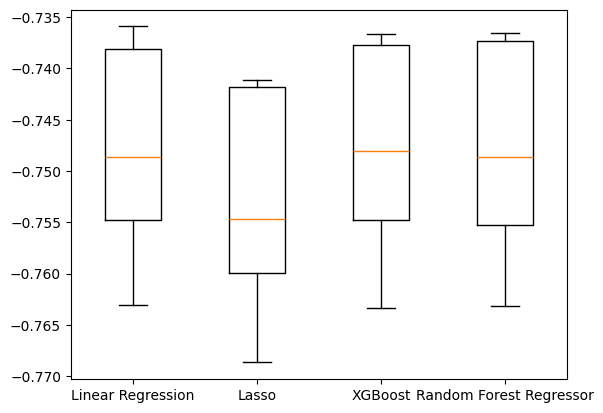

[array([-0.75479541, -0.76306521, -0.73590922, -0.73810431, -0.74860133]), array([-0.75992643, -0.76866977, -0.74181135, -0.74114705, -0.75465983]), array([-0.75474725, -0.76334495, -0.73668389, -0.73775243, -0.74805268]), array([-0.75523513, -0.76319786, -0.73650536, -0.73734882, -0.74860883])]


In [21]:
# Compare the four models with cross validation

models = {'Linear Regression':lin_search, 'Lasso':lasso_search, 'XGBoost':boost_search, 
          'Random Forest Regressor':rfr_search}

results = []

for model in models.values():
    kf = KFold(n_splits = 5, random_state = 52, shuffle = True)
    cv_results = cross_val_score(model, Xtrain, ytrain, cv = kf)
    results.append(cv_results)

# Create a boxplot to show the comparison    

plt.boxplot(results, labels = models.keys())
plt.show()

print(results)

The boxplot visually seems to indicate that the Linear model does the best; the upper margin of its box is slightly higher than the others, and both top and bottom whiskers are higher than those of the other models. 

We will calculate some extra stats from each model and create a table of comparison for numerical analysis.

In [23]:
# Linear regression, model lin_search

cv_train = cross_val_score(lin_search, Xtrain, ytrain, cv=5, scoring = 'neg_mean_squared_error')
cv_test = cross_val_score(lin_search, Xtest, ytest, cv=5, scoring = 'neg_mean_squared_error')

cv_train_lin = cv_train.mean()
cv_test_lin = cv_test.mean()
cv_test_std_lin = cv_test.std()

print ('Mean cross validation train score: ' + str(cv_train_lin))
print ('Mean cross validation test score: ' + str(cv_test_lin))
print ('Standard deviation in cv test scores: ' + str(cv_test_std_lin))

Mean cross validation train score: -0.7487784434024454
Mean cross validation test score: -0.7434846910898371
Standard deviation in cv test scores: 0.013870001743173507


In [24]:
# Lasso regression, model lasso_search

cv_train = cross_val_score(lasso_search, Xtrain, ytrain, cv = 5, scoring = 'neg_mean_squared_error')
cv_test = cross_val_score(lasso_search, Xtest, ytest, cv = 5, scoring = 'neg_mean_squared_error')

cv_train_lasso = cv_train.mean()
cv_test_lasso = cv_test.mean()
cv_test_std_lasso = cv_test.std()

print ('Mean cross validation train score: ' + str(cv_train_lasso))
print ('Mean cross validation test score: ' + str(cv_test_lasso))
print ('Standard deviation in cv test scores: ' + str(cv_test_std_lasso))

Mean cross validation train score: -0.7536399105522057
Mean cross validation test score: -0.7437437855836351
Standard deviation in cv test scores: 0.01550349679881597


In [25]:
# XGBoost, model boost_search

cv_train = cross_val_score(boost_search, Xtrain, ytrain, cv = 5, scoring = 'neg_mean_squared_error')
cv_test = cross_val_score(boost_search, Xtest, ytest, cv = 5, scoring = 'neg_mean_squared_error')

cv_train_boost = cv_train.mean()
cv_test_boost = cv_test.mean()
cv_test_std_boost = cv_test.std()

print ('Mean cross validation train score: ' + str(cv_train_boost))
print ('Mean cross validation test score: ' + str(cv_test_boost))
print ('Standard deviation in cv test scores: ' + str(cv_test_std_boost))

Mean cross validation train score: -0.748340765139614
Mean cross validation test score: -0.7421402724677197
Standard deviation in cv test scores: 0.014179871848231143


In [26]:
# Random forest regressor, model rfr_search

cv_train = cross_val_score(rfr_search, Xtrain, ytrain, cv = 5, scoring = 'neg_mean_squared_error')
cv_test = cross_val_score(rfr_search, Xtest, ytest, cv = 5, scoring = 'neg_mean_squared_error')

cv_train_rfr = cv_train.mean()
cv_test_rfr = cv_test.mean()
cv_test_std_rfr = cv_test.std()

print ('Mean cross validation train score: ' + str(cv_train_rfr))
print ('Mean cross validation test score: ' + str(cv_test_rfr))
print ('Standard deviation in cv test scores: ' + str(cv_test_std_rfr))

Mean cross validation train score: -0.7486463163859558
Mean cross validation test score: -0.7436407913725794
Standard deviation in cv test scores: 0.01451433912199427


In [27]:
names = ['Linear Regression', 'Lasso', 'XGBoost', 'Random Forest']
trains = [cv_train_lin, cv_train_lasso, cv_train_boost, cv_train_rfr]
tests = [cv_test_lin, cv_test_lasso, cv_test_boost, cv_test_rfr]
best_mses = [lin_search.best_score_, lasso_search.best_score_, boost_search.best_score_, rfr_search.best_score_]

df = pd.DataFrame(list(zip(names, trains, tests, best_mses)), 
               columns =['Algorithm', 'NMSE Training Score', 'NMSE Testing Score', 'NMSE Best Score']) 
print(df)

           Algorithm  NMSE Training Score  NMSE Testing Score  NMSE Best Score
0  Linear Regression            -0.748778           -0.743485        -0.748575
1              Lasso            -0.753640           -0.743744        -0.753640
2            XGBoost            -0.748341           -0.742140        -0.748309
3      Random Forest            -0.748646           -0.743641        -0.748410


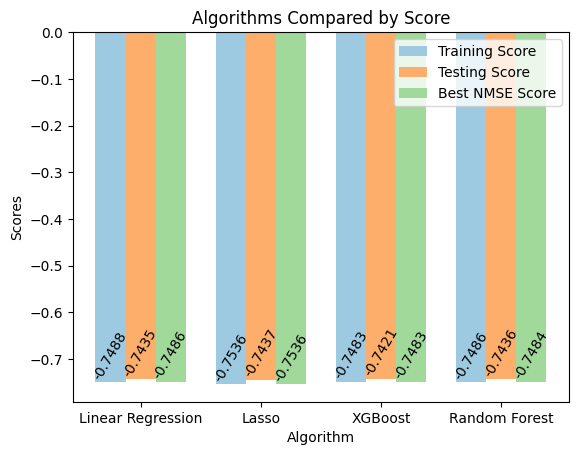

In [28]:
# A bar plot to visually evaluate these scores

N = 4
ind = np.arange(N)  
width = 0.25
cmap = plt.get_cmap('tab20c')
c1 = cmap(2/20)
c2 = cmap(6/20)
c3 = cmap(10/20)
    
xvals = trains
bar1 = plt.bar(ind, xvals, width, color=c1) 
  
yvals = tests
bar2 = plt.bar(ind+width, yvals, width, color=c2) 
  
zvals = best_mses 
bar3 = plt.bar(ind+width*2, zvals, width, color=c3) 
  
plt.xlabel("Algorithm") 
plt.ylabel('Scores') 
plt.title("Algorithms Compared by Score") 
 
plt.xticks(ind+width,names) 
plt.legend((bar1, bar2, bar3), ('Training Score', 'Testing Score', 'Best NMSE Score')) 

for bar in bar1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom', rotation=60)

for bar in bar2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom', rotation=60)

for bar in bar3:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom', rotation=60)
    
plt.show()

Interestingly, all of the models had better testing scores than training scores. However, Linear Regression seems to beat the others. It has the highest training score, which is almost equal to its testing score. Its best score is one of the highest as well. Due to its consistency and quick running speed, I think that will be the best fit for this project, and as such, I will perform another GridSearchCV to refine it one last time. 

In [30]:
lin = LinearRegression()

lin_params = {'fit_intercept':[True, False], 
             'copy_X':[True, False],
             'positive':[False, True]}

linModel = GridSearchCV(lin, lin_params, scoring='neg_mean_squared_error', cv=10)

linModel.fit(Xtrain, ytrain)

print("The best negative MSE score for the Linear Regression model is " + str(lin_search.best_score_) 
      + '\nThe best parameters are ' + str(lin_search.best_params_))

training = cross_val_score(linModel, Xtrain, ytrain, cv=10, scoring='neg_mean_squared_error')

print("The model's NMSE training CV score is " + str(training.mean()))

ypred = linModel.predict(Xtest)
testing = cross_val_score(linModel, Xtest, ytest, cv=10, scoring='neg_mean_squared_error')

print("The model's NMSE testing CV score is "+ str(testing.mean()))

The best negative MSE score for the Linear Regression model is -0.7485746361602028
The best parameters are {'copy_X': True, 'fit_intercept': True, 'positive': True}
The model's NMSE training CV score is -0.747773582924948
The model's NMSE testing CV score is -0.7426515099102272
